# Ingredient Recognition - Fine-tuning Vision Transformers

This notebook focuses on fine-tuning pre-trained Vision Transformers on the Food-101 dataset using Ingredients-101 labels. The goal is to train a model capable of recognizing ingredients in an image. For this purpose, multiple Vision Transformer models will be tested and evaluated.

## Set up the Environment

### Import required libraries

In [8]:
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
import warnings
warnings.filterwarnings("ignore")
import wandb
from PIL import Image
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as T
from pathlib import Path
from PIL import Image
import datasets
import os
import json
import jsonlines
from timm import create_model
from transformers.optimization import get_cosine_schedule_with_warmup
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import random
import time
from tqdm import tqdm
import wandb
import torch
from torch.optim import AdamW
import numpy as np
from tqdm import tqdm

from torchvision import transforms as T
from PIL import Image
from sklearn.metrics import multilabel_confusion_matrix

from prettytable import PrettyTable

## Prepare to tune the model

### Load the data

In [18]:
# load dataset
data_files = {"train": "../data/food-ingredients/train.jsonl", "val": "../data/food-ingredients/val.jsonl", "test": "../data/food-ingredients/test.jsonl"}

dataset = datasets.load_dataset('json', data_files=data_files)

In [19]:
def read_data(path, file):
    with open(path / file, 'r') as f:
        data = f.read().strip().split('\n')
    return data

In [20]:
annotations_path = Path("../data/ingredients-101/Annotations/")
ingredients_path = 'ingredients_simplified.txt'

ingredients_simplified = read_data(annotations_path, ingredients_path)
ingredients_simplified_prep = [ingredient.strip() for sublist in ingredients_simplified for ingredient in sublist.split(',')]

unique_ingredients = list(set(ingredients_simplified_prep))
num_unique_ingredients = len(unique_ingredients)
num_unique_ingredients

227

### Perform transformations

To identify a suitable augmentation method, four different strategies are implemented:

- No augmentation
- Simple augmentation
- Han Augmentation [1]
- Gao Augmentation [2]

In [21]:
img_size = (224, 224)
AUGMENTATION = 'han'

# no augmentation
if AUGMENTATION == 'no':
    tfms_no_aug = T.Compose([
        T.Resize(img_size),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# simple augmentation
if AUGMENTATION == 'simple':
    tfms_simple_aug = T.Compose([
        T.Resize(img_size),
        T.RandomHorizontalFlip(),
        T.RandomRotation(30),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# Han augmentation
if AUGMENTATION == 'han':
    tfms_han_aug = T.Compose([
        T.Resize(img_size),
        T.RandomResizedCrop(img_size, scale=(0.08, 1.0)),
        T.RandomRotation(degrees=10),
        T.RandomAffine(degrees=0, scale=(1.0, 1.1)),  # Dies ist für den Zoom-Effekt
        T.RandomPerspective(distortion_scale=0.2, p=0.5),
        T.ColorJitter(brightness=0.3, contrast=0.3),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# Gao augmentation
class GaussianBlur(object):
    def __init__(self, kernel_size, sigma=(0.1, 2.0)):
        self.kernel_size = kernel_size
        self.sigma = sigma

    def __call__(self, img):
        return T.functional.gaussian_blur(img, self.kernel_size, random.uniform(*self.sigma))

class Solarization(object):
    def __init__(self, threshold=128):
        self.threshold = threshold

    def __call__(self, img):
        return T.functional.solarize(img, self.threshold)

if AUGMENTATION == 'gao':
    tfms_gao_aug = T.Compose([
        T.RandomResizedCrop(size=224, scale=(0.08, 1.0)),
        T.RandomHorizontalFlip(p=0.5),
        T.TrivialAugmentWide(),
        GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        T.RandomGrayscale(p=0.2),
        Solarization(threshold=128),
        T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        T.ToTensor(),  # Convert to tensor before RandomErasing
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random'),
    ])

valid_tfms = T.Compose([
    T.Resize(img_size),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [22]:
# function to apply transformations to the training data batch
# It opens images, augmentation, converts ingredients to one-hot encoded labels
def transforms(batch):
    batch['image'] = [Image.open(x).convert('RGB') for x in batch['image']]
    inputs = [tfms_han_aug(x) for x in batch['image']]
    batch['pixel_values'] = inputs

    labels = torch.zeros((len(batch['ingredients']), num_unique_ingredients))

    for i, ingredient_indices in enumerate(batch['ingredients']):
        labels[i, ingredient_indices] = 1

    batch['labels'] = labels

    return batch

# function to apply transformations to the validation data batch
def transforms_valid(batch):
    batch['image'] = [Image.open(x).convert('RGB') for x in batch['image']]
    inputs = [valid_tfms(x) for x in batch['image']]
    batch['pixel_values'] = inputs

    labels = torch.zeros((len(batch['ingredients']), num_unique_ingredients))

    for i, ingredient_indices in enumerate(batch['ingredients']):
        labels[i, ingredient_indices] = 1

    batch['labels'] = labels

    return batch

In [23]:
# apply transformations to the dataset
train_dataset = dataset['train'].with_transform(transforms)
valid_dataset = dataset['val'].with_transform(transforms_valid)
test_dataset = dataset['test'].with_transform(transforms_valid)

# check the length of the datasets
len(train_dataset), len(valid_dataset), len(test_dataset)

(68175, 7575, 25250)

In [24]:
# TODO: check if this is needed
# # for Han Augmentation
# train_dataset = dataset['train'].with_transform(lambda example: {
#     'pixel_values': tfms(Image.open(example['image']).convert('RGB')),
#     'labels': example['labels']  # oder was auch immer Ihr Label-Feld ist
# })
# valid_dataset = dataset['val'].with_transform(valid_tfms)
# test_dataset = dataset['test'].with_transform(valid_tfms)

# len(train_dataset), len(valid_dataset), len(test_dataset)

In [25]:
# Custom collate function that stacks 'pixel_values' and 'labels' from each sample into tensors
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.stack([x['labels'] for x in batch]).float()
    }

In [26]:
# create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# check size of the data
len(train_loader), len(valid_loader), len(test_loader)

(2131, 237, 790)

In [23]:
# # uncomment for testing with less data

# # Anzahl der zu verwendenden Samples festlegen
# from sklearn.model_selection import train_test_split
# from torch.utils.data import Subset


# subset_size = 0.1  # Nutze 10% der Daten
# train_indices, _ = train_test_split(range(len(train_dataset)), train_size=subset_size, random_state=42)
# valid_indices, _ = train_test_split(range(len(valid_dataset)), train_size=subset_size, random_state=42)
# test_indices, _ = train_test_split(range(len(test_dataset)), train_size=subset_size, random_state=42)

# # Erstellen der Subsets
# train_subset = Subset(train_dataset, train_indices)
# valid_subset = Subset(valid_dataset, valid_indices)
# test_subset = Subset(test_dataset, test_indices)

# # Erstellen der DataLoader
# train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, collate_fn=collate_fn)
# valid_loader = DataLoader(valid_subset, batch_size=32, shuffle=False, collate_fn=collate_fn)
# test_loader = DataLoader(test_subset, batch_size=32, shuffle=False, collate_fn=collate_fn)

## Tune the model

### Define evaluation functions

In [24]:
def multi_label_f1(y_true, y_pred, threshold=0.25, average='weighted', labels=None, pos_label=1, sample_weight=None):
    y_pred = (y_pred > threshold).astype(int)
    return f1_score(y_true, y_pred, average=average, labels=labels, pos_label=pos_label, sample_weight=sample_weight, zero_division=0.0)

def multi_label_accuracy(y_true, y_pred, threshold=0.25):
    y_pred = (y_pred > threshold).astype(int)
    correct_predictions = np.sum(y_true == y_pred)
    total_predictions = y_true.size
    accuracy = correct_predictions / total_predictions
    return accuracy

def multi_label_accuracy_samples(y_true, y_pred, threshold=0.25):
    y_pred = (y_pred > threshold).astype(int)
    sample_accuracies = [accuracy_score(y_true[i], y_pred[i]) for i in range(len(y_true))]
    return sum(sample_accuracies) / len(sample_accuracies)

def multi_label_recall(y_true, y_pred, threshold=0.25, average='weighted', labels=None, pos_label=1, sample_weight=None):
    y_pred = (y_pred > threshold).astype(int)
    return recall_score(y_true, y_pred, average=average, labels=labels, pos_label=pos_label, sample_weight=sample_weight, zero_division=0.0)

def multi_label_precision(y_true, y_pred, threshold=0.25, average='weighted', labels=None, pos_label=1, sample_weight=None):
    y_pred = (y_pred > threshold).astype(int)
    return precision_score(y_true, y_pred, average=average, labels=labels, pos_label=pos_label, sample_weight=sample_weight, zero_division=0.0)

def evaluate_model(actuals, predictions):
    accuracy = multi_label_accuracy(actuals, predictions)
    accuracy_samples = multi_label_accuracy_samples(actuals, predictions)
    recall_weighted = multi_label_recall(actuals, predictions, average='weighted')
    recall_samples = multi_label_recall(actuals, predictions, average='samples')
    precision_weighted = multi_label_precision(actuals, predictions, average='weighted')
    precision_samples = multi_label_precision(actuals, predictions, average='samples')
    f1_micro = multi_label_f1(actuals, predictions, average='micro')
    f1_samples = multi_label_f1(actuals, predictions, average='samples')
    f1_macro = multi_label_f1(actuals, predictions, average='macro')
    f1_weighted = multi_label_f1(actuals, predictions, average='weighted')
    return accuracy, accuracy_samples, recall_weighted, recall_samples, precision_weighted, precision_samples, f1_micro, f1_samples, f1_macro, f1_weighted


### Prepare logging

In [ ]:
os.environ["WANDB_NOTEBOOK_NAME"] = 'fine_tuning_vit.ipynb'
os.environ["WANDB_DISABLE_SYMLINKS"] = "1"

### Optimize the learning rate

To determine the most suitable learning rate, a function is implemented that gradually increases the learning rate while logging the loss. The function uses an exponential increase in learning rate over a specified number of iterations, allowing observation of how the model's loss responds to different learning rates. 

In [25]:
# function for learning rate test
def train_with_lr_test(model_name, batch_size=32, min_lr=1e-7, max_lr=1, num_iterations=100):

    # initialize wandb for experiment tracking
    wandb.init(project="finetuning-vit", config={
        "model_name": model_name,
        "batch_size": batch_size,
        "min_lr": min_lr,
        "max_lr": max_lr,
        "num_iterations": num_iterations,
    })
    wandb.run.name = f"{model_name}-lr-test"
    
    # set up device
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Using {device}')

    model = create_model(model_name, num_classes=num_unique_ingredients, pretrained=True)
    model.to(device)

    # define optimizer and loss function
    optimizer = AdamW(model.parameters(), lr=min_lr)
    loss_fn = nn.BCEWithLogitsLoss()
    
    # define a function to calculate learning rate for each iteration
    lr_lambda = lambda x: np.exp(x * np.log(max_lr / min_lr) / num_iterations)
    
    model.train()
    iteration = 0
    pbar = tqdm(total=num_iterations, desc="LR Test Progress")
    
    while iteration < num_iterations:
        for batch in train_loader:
            if iteration >= num_iterations:
                break
            
            inputs = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            
            optimizer.zero_grad()
            logits = model(inputs)
            loss = loss_fn(logits, labels)
            loss.backward()
            
            # Update learning rate
            for param_group in optimizer.param_groups:
                param_group['lr'] = min_lr * lr_lambda(iteration)
            
            # Update model parameters
            optimizer.step()

            # Log loss and learning rate
            current_lr = optimizer.param_groups[0]['lr']
            wandb.log({"loss": loss.item(), "learning_rate": current_lr, "iteration": iteration})

            iteration += 1
            pbar.update(1)

    pbar.close()
    wandb.finish()

# Uncomment to run the learning rate test
train_with_lr_test("deit3_medium_patch16_224", min_lr=1e-7, max_lr=1e-1, num_iterations=500)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ahirsch (htwbe). Use `wandb login --relogin` to force relogin


Using cuda:0


LR Test Progress: 100%|██████████| 500/500 [09:30<00:00,  1.14s/it]


iteration,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▄▅▆█
loss,▄▄▄▄▄▄▄▄▄▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▂▁▁▁▁▁
iteration,499
learning_rate,0.09727
loss,0.13397


### Train the model with frozen layers

In [31]:
# function to train a model with frozen layers
def train_with_freezing(model_name, batch_size=8, epochs=1, lr=2e-4, augmentation=False, scheduler='none', unfreeze_last_n=4, freeze_epochs=3):
    os.environ["WANDB_DISABLE_SYMLINKS"] = "1"
    wandb.init(project="finetuning-vit", config={
        "model_name": model_name,
        "batch_size": batch_size,
        "epochs": epochs,
        "learning_rate": lr,
        "augmentation": augmentation,
        "scheduler": scheduler,
        "unfreeze_last_n": unfreeze_last_n,
        "freeze_epochs": freeze_epochs
    })
    wandb.run.name = f"{model_name}-lr-{lr}-augmented-{augmentation}-scheduler-{scheduler}"
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Using {device}')

    print("Loading the model...")
    model = create_model(model_name, num_classes=num_unique_ingredients, pretrained=True)
    print(f"The model has {num_unique_ingredients} output units.")
    model.to(device)
    print("Model loaded.")

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * len(train_loader)),
        num_training_steps=len(train_loader) * epochs
    )

    
    def freeze_layers(freeze=True):
        if freeze:
            # freeze all layers initially
            for param in model.parameters():
                param.requires_grad = False

            # unfreeze the last 'unfreeze_last_n' layers
            if 'volo' in model_name:
                trainable_params = list(model.named_parameters())[-unfreeze_last_n:]
                for name, param in trainable_params:
                    param.requires_grad = True
            elif 'swin' in model_name:
                layers = list(model.layers)
                for layer in layers[-unfreeze_last_n:]:
                    for param in layer.parameters():
                        param.requires_grad = True
            elif 'deit' in model_name:
                if hasattr(model, 'blocks'):
                    blocks = list(model.blocks)
                    for block in blocks[-unfreeze_last_n:]:
                        for param in block.parameters():
                            param.requires_grad = True
                else:
                    print("Warning: Unable to identify blocks in DeiT model. Unfreezing last layers based on parameter count.")
                    trainable_params = list(model.parameters())[-unfreeze_last_n * 100:]  # approximation
                    for param in trainable_params:
                        param.requires_grad = True
            else:
                trainable_params = list(model.parameters())[-unfreeze_last_n * 100:]  # approximation
                for param in trainable_params:
                    param.requires_grad = True

            print(f"Froze all layers except approximately the last {unfreeze_last_n} layers of the model.")
        else:
            # Unfreeze all layers
            for param in model.parameters():
                param.requires_grad = True
            print("Unfroze all layers of the model.")

    # Initially freeze layers
    freeze_layers(freeze=True)

    for epoch in range(epochs):
        # Unfreeze all layers after freeze_epochs
        if epoch == freeze_epochs:
            freeze_layers(freeze=False)
            print("Unfreezing all layers and reinitializing optimizer")
            optimizer = optim.AdamW(model.parameters(), lr=lr)
            scheduler = get_cosine_schedule_with_warmup(
                optimizer,
                num_warmup_steps=int(0.1 * len(train_loader)),
                num_training_steps=len(train_loader) * (epochs - freeze_epochs)
            )
        elif epoch < freeze_epochs:
            # Initial optimizer setup
            optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
            scheduler = get_cosine_schedule_with_warmup(
                optimizer,
                num_warmup_steps=int(0.1 * len(train_loader)),
                num_training_steps=len(train_loader) * epochs
            )

        ## Training

        model.train()
        running_loss = 0.0
        predictions, actuals = [], []

        print(f"\nStarting training epoch {epoch}...")

        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch}"):
            inputs = batch['pixel_values'].to(device)
            logits = model(inputs)
            labels = batch['labels'].to(device) 

            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            running_loss += loss.item()
            
            predictions.append(torch.sigmoid(logits).detach().cpu().numpy())
            actuals.append(labels.cpu().numpy())

        predictions = np.vstack(predictions)
        actuals = np.vstack(actuals)

        print("Unique values in labels:", np.unique(actuals))
        is_binary = np.all(np.isin(actuals, [0, 1]))
        print("Data is binary:", is_binary)
        
        train_loss = running_loss / len(train_loader)
        train_accuracy, train_accuracy_samples, train_recall_weighted, train_recall_samples, train_precision_weighted, train_precision_samples, train_f1_micro, train_f1_samples, train_f1_macro, train_f1_weighted = evaluate_model(actuals, predictions)

        print(f"{train_loss = :.3f} | {train_f1_samples = :.3f}")

        for param_group in optimizer.param_groups:
            lr = param_group['lr']
            
        wandb.log({"learning_rate": lr,"train_loss": train_loss, "epoch": epoch, "train_accuracy": train_accuracy, "train_accuracy_samples": train_accuracy_samples, "train_recall_weighted": train_recall_weighted, "train_recall_samples": train_recall_samples, "train_precision_weighted": train_precision_weighted, "train_precision_samples": train_precision_samples, "train_f1_micro": train_f1_micro, "train_f1_samples": train_f1_samples, "train_f1_macro": train_f1_macro, "train_f1_weighted": train_f1_weighted})
    
        
        ## Validation

        model.eval()
        running_loss = 0.0
        
        print(f"Starting validation epoch {epoch}...")

        predictions, actuals = [], []
        
        for batch in tqdm(valid_loader, desc=f"Validation Epoch {epoch}"):
            with torch.no_grad():
                inputs = batch['pixel_values'].to(device)
                logits = model(inputs)
                labels = batch['labels'].to(device) 
            loss = loss_fn(logits, labels)
            running_loss += loss.item()

            predictions.append(torch.sigmoid(logits).detach().cpu().numpy())
            actuals.append(labels.cpu().numpy())

        predictions = np.vstack(predictions)
        actuals = np.vstack(actuals)
        
        
        valid_loss = running_loss / len(valid_loader)

        valid_accuracy, valid_accuracy_samples, valid_recall_weighted, valid_recall_samples, valid_precision_weighted, valid_precision_samples, valid_f1_micro, valid_f1_samples, valid_f1_macro, valid_f1_weighted = evaluate_model(actuals, predictions)

        print(f"{valid_loss = :.3f} | {valid_f1_samples = :.3f}")
        
        wandb.log({"valid_loss": valid_loss, "epoch": epoch, "valid_accuracy": valid_accuracy, "valid_accuracy_samples": valid_accuracy_samples, "valid_recall_weighted": valid_recall_weighted, "valid_recall_samples": valid_recall_samples, "valid_precision_weighted": valid_precision_weighted, "valid_precision_samples": valid_precision_samples, "valid_f1_micro": valid_f1_micro, "valid_f1_samples": valid_f1_samples, "valid_f1_macro": valid_f1_macro, "valid_f1_weighted": valid_f1_weighted})
        
        model_path = f'./models/{model_name}-freezing-pascal-epoch-{epoch}.pth'
        torch.save(model.state_dict(), model_path)

    ## Testing
    
    print(f"Starting test evaluation...")
    test_start_time = time.time()

    predictions, actuals = [], []

    for batch in tqdm(test_loader, desc="Testing"):
        with torch.no_grad():
            inputs = batch['pixel_values'].to(device)
            logits = model(inputs)
            labels = batch['labels'].to(device)
        predictions.append(torch.sigmoid(logits).detach().cpu().numpy())
        actuals.append(labels.cpu().numpy())

    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)
    
    test_end_time = time.time()
    print(f"Completed test evaluation in {test_end_time - test_start_time:.2f} seconds")
    
    test_accuracy, test_accuracy_samples, test_recall_weighted, test_recall_samples, test_precision_weighted, test_precision_samples, test_f1_micro, test_f1_samples, test_f1_macro, test_f1_weighted = evaluate_model(actuals, predictions)
    
    wandb.log({"test_accuracy": test_accuracy, "test_accuracy_samples": test_accuracy_samples, "test_recall_weighted": test_recall_weighted, "test_recall_samples": test_recall_samples, "test_precision_weighted": test_precision_weighted, "test_precision_samples": test_precision_samples, "test_f1_micro": test_f1_micro, "test_f1_samples": test_f1_samples, "test_f1_macro": test_f1_macro, "test_f1_weighted": test_f1_weighted})

    wandb.finish()

    return model

model_name = 'deit3_medium_patch16_224'
model = train_with_freezing(model_name, batch_size=32, epochs=5, lr=2e-4, unfreeze_last_n=1, freeze_epochs=2)

Using cuda:0
Loading the model...
The model has 227 output units.
Model loaded.
Froze all layers except approximately the last 1 layers of the model.

Starting training epoch 0...


Training Epoch 0: 100%|██████████| 2131/2131 [14:48<00:00,  2.40it/s]


Unique values in labels: [0. 1.]
Data is binary: True
train_loss = 0.297 | train_f1_samples = 0.133
Starting validation epoch 0...


Validation Epoch 0: 100%|██████████| 237/237 [01:10<00:00,  3.34it/s]


valid_loss = 0.278 | valid_f1_samples = 0.151

Starting training epoch 1...


Training Epoch 1: 100%|██████████| 2131/2131 [10:01<00:00,  3.54it/s]


Unique values in labels: [0. 1.]
Data is binary: True
train_loss = 0.277 | train_f1_samples = 0.153
Starting validation epoch 1...


Validation Epoch 1: 100%|██████████| 237/237 [00:43<00:00,  5.49it/s]


valid_loss = 0.272 | valid_f1_samples = 0.164
Unfroze all layers of the model.
Unfreezing all layers and reinitializing optimizer

Starting training epoch 2...


Training Epoch 2: 100%|██████████| 2131/2131 [15:44<00:00,  2.26it/s]


Unique values in labels: [0. 1.]
Data is binary: True
train_loss = 0.083 | train_f1_samples = 0.562
Starting validation epoch 2...


Validation Epoch 2: 100%|██████████| 237/237 [00:43<00:00,  5.48it/s]


valid_loss = 0.056 | valid_f1_samples = 0.696

Starting training epoch 3...


Training Epoch 3: 100%|██████████| 2131/2131 [15:45<00:00,  2.25it/s]


Unique values in labels: [0. 1.]
Data is binary: True
train_loss = 0.055 | train_f1_samples = 0.702
Starting validation epoch 3...


Validation Epoch 3: 100%|██████████| 237/237 [00:43<00:00,  5.42it/s]


valid_loss = 0.038 | valid_f1_samples = 0.798

Starting training epoch 4...


Training Epoch 4: 100%|██████████| 2131/2131 [16:30<00:00,  2.15it/s]


Unique values in labels: [0. 1.]
Data is binary: True
train_loss = 0.040 | train_f1_samples = 0.784
Starting validation epoch 4...


Validation Epoch 4: 100%|██████████| 237/237 [00:44<00:00,  5.27it/s]


valid_loss = 0.034 | valid_f1_samples = 0.823
Starting test evaluation...


Testing: 100%|██████████| 790/790 [04:26<00:00,  2.96it/s]


Completed test evaluation in 266.58 seconds


epoch,▁▁▃▃▅▅▆▆██
learning_rate,█▇▆▃▁
test_accuracy,▁
test_accuracy_samples,▁
test_f1_macro,▁
test_f1_micro,▁
test_f1_samples,▁
test_f1_weighted,▁
test_precision_samples,▁
test_precision_weighted,▁
test_recall_samples,▁


### Train the model

In [32]:
# function to train a model
def train(model_name, batch_size=8, epochs=1, lr=2e-4, augmentation=False, scheduler='none'):
    os.environ["WANDB_DISABLE_SYMLINKS"] = "1"
    wandb.init(project="finetuning-vit", config={
        "model_name": model_name,
        "batch_size": batch_size,
        "epochs": epochs,
        "learning_rate": lr,
        "augmentation": augmentation,
        "scheduler": scheduler,
    })
    wandb.run.name = f"{model_name}-lr-{lr}-augmented-{augmentation}-scheduler-{scheduler}"
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Using {device}')

    print("Loading the model...")
    model = create_model(model_name, num_classes=num_unique_ingredients, pretrained=True)
    print(f"The model has {num_unique_ingredients} output units.")
    model.to(device)
    print("Model loaded.")

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * len(train_loader)),
        num_training_steps=len(train_loader) * epochs
    )

    for epoch in range(epochs):

        ## Training

        model.train()
        running_loss = 0.0
        predictions, actuals = [], []

        print(f"\nStarting training epoch {epoch}...")

        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch}"):
            inputs = batch['pixel_values'].to(device)
            logits = model(inputs)
            labels = batch['labels'].to(device) 

            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            running_loss += loss.item()
            
            predictions.append(torch.sigmoid(logits).detach().cpu().numpy())
            actuals.append(labels.cpu().numpy())

        predictions = np.vstack(predictions)
        actuals = np.vstack(actuals)

        print("Unique values in labels:", np.unique(actuals))
        is_binary = np.all(np.isin(actuals, [0, 1]))
        print("Data is binary:", is_binary)
        
        train_loss = running_loss / len(train_loader)
        train_accuracy, train_accuracy_samples, train_recall_weighted, train_recall_samples, train_precision_weighted, train_precision_samples, train_f1_micro, train_f1_samples, train_f1_macro, train_f1_weighted = evaluate_model(actuals, predictions)

        print(f"{train_loss = :.3f} | {train_f1_samples = :.3f}")

        for param_group in optimizer.param_groups:
            lr = param_group['lr']
            
        wandb.log({"learning_rate": lr,"train_loss": train_loss, "epoch": epoch, "train_accuracy": train_accuracy, "train_accuracy_samples": train_accuracy_samples, "train_recall_weighted": train_recall_weighted, "train_recall_samples": train_recall_samples, "train_precision_weighted": train_precision_weighted, "train_precision_samples": train_precision_samples, "train_f1_micro": train_f1_micro, "train_f1_samples": train_f1_samples, "train_f1_macro": train_f1_macro, "train_f1_weighted": train_f1_weighted})
    
        
        ## Validation

        model.eval()
        running_loss = 0.0
        
        print(f"Starting validation epoch {epoch}...")

        predictions, actuals = [], []
        
        for batch in tqdm(valid_loader, desc=f"Validation Epoch {epoch}"):
            with torch.no_grad():
                inputs = batch['pixel_values'].to(device)
                logits = model(inputs)
                labels = batch['labels'].to(device) 
            loss = loss_fn(logits, labels)
            running_loss += loss.item()

            predictions.append(torch.sigmoid(logits).detach().cpu().numpy())
            actuals.append(labels.cpu().numpy())

        predictions = np.vstack(predictions)
        actuals = np.vstack(actuals)
        
        
        valid_loss = running_loss / len(valid_loader)

        valid_accuracy, valid_accuracy_samples, valid_recall_weighted, valid_recall_samples, valid_precision_weighted, valid_precision_samples, valid_f1_micro, valid_f1_samples, valid_f1_macro, valid_f1_weighted = evaluate_model(actuals, predictions)

        print(f"{valid_loss = :.3f} | {valid_f1_samples = :.3f}")
        
        wandb.log({"valid_loss": valid_loss, "epoch": epoch, "valid_accuracy": valid_accuracy, "valid_accuracy_samples": valid_accuracy_samples, "valid_recall_weighted": valid_recall_weighted, "valid_recall_samples": valid_recall_samples, "valid_precision_weighted": valid_precision_weighted, "valid_precision_samples": valid_precision_samples, "valid_f1_micro": valid_f1_micro, "valid_f1_samples": valid_f1_samples, "valid_f1_macro": valid_f1_macro, "valid_f1_weighted": valid_f1_weighted})
        
        model_path = f'./models/{model_name}-pascal-epoch-{epoch}.pth'
        torch.save(model.state_dict(), model_path)

    ## Testing
    
    print(f"Starting test evaluation...")
    test_start_time = time.time()

    predictions, actuals = [], []

    for batch in tqdm(test_loader, desc="Testing"):
        with torch.no_grad():
            inputs = batch['pixel_values'].to(device)
            logits = model(inputs)
            labels = batch['labels'].to(device)
        predictions.append(torch.sigmoid(logits).detach().cpu().numpy())
        actuals.append(labels.cpu().numpy())

    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)
    
    test_end_time = time.time()
    print(f"Completed test evaluation in {test_end_time - test_start_time:.2f} seconds")
    
    test_accuracy, test_accuracy_samples, test_recall_weighted, test_recall_samples, test_precision_weighted, test_precision_samples, test_f1_micro, test_f1_samples, test_f1_macro, test_f1_weighted = evaluate_model(actuals, predictions)
    
    wandb.log({"test_accuracy": test_accuracy, "test_accuracy_samples": test_accuracy_samples, "test_recall_weighted": test_recall_weighted, "test_recall_samples": test_recall_samples, "test_precision_weighted": test_precision_weighted, "test_precision_samples": test_precision_samples, "test_f1_micro": test_f1_micro, "test_f1_samples": test_f1_samples, "test_f1_macro": test_f1_macro, "test_f1_weighted": test_f1_weighted})

    wandb.finish()

    return model

In [33]:
# MODEL_NAME = 'swin_s3_small_224'
MODEL_NAME = 'deit3_medium_patch16_224'
# MODEL_NAME = 'volo_d3_224'
# MODEL_NAME = 'vit_base_patch16_224'
# MODEL_NAME = 'vit_base_patch32_clip_224'
model = train(MODEL_NAME, batch_size=32, epochs=15, lr=2e-4, augmentation=AUGMENTATION, scheduler='cosine')

Using cuda:0
Loading the model...
The model has 227 output units.
Model loaded.

Starting training epoch 0...


Training Epoch 0: 100%|██████████| 2131/2131 [22:35<00:00,  1.57it/s]


Unique values in labels: [0. 1.]
Data is binary: True
train_loss = 0.105 | train_f1_samples = 0.473
Starting validation epoch 0...


Validation Epoch 0: 100%|██████████| 237/237 [01:15<00:00,  3.15it/s]


valid_loss = 0.065 | valid_f1_samples = 0.642

Starting training epoch 1...


Training Epoch 1: 100%|██████████| 2131/2131 [16:34<00:00,  2.14it/s]


Unique values in labels: [0. 1.]
Data is binary: True
train_loss = 0.070 | train_f1_samples = 0.619
Starting validation epoch 1...


Validation Epoch 1: 100%|██████████| 237/237 [00:43<00:00,  5.42it/s]


valid_loss = 0.055 | valid_f1_samples = 0.700

Starting training epoch 2...


Training Epoch 2: 100%|██████████| 2131/2131 [15:46<00:00,  2.25it/s]


Unique values in labels: [0. 1.]
Data is binary: True
train_loss = 0.061 | train_f1_samples = 0.668
Starting validation epoch 2...


Validation Epoch 2: 100%|██████████| 237/237 [00:45<00:00,  5.22it/s]


valid_loss = 0.049 | valid_f1_samples = 0.734

Starting training epoch 3...


Training Epoch 3: 100%|██████████| 2131/2131 [31:14<00:00,  1.14it/s]


Unique values in labels: [0. 1.]
Data is binary: True
train_loss = 0.056 | train_f1_samples = 0.699
Starting validation epoch 3...


Validation Epoch 3: 100%|██████████| 237/237 [01:29<00:00,  2.63it/s]


valid_loss = 0.047 | valid_f1_samples = 0.755

Starting training epoch 4...


Training Epoch 4: 100%|██████████| 2131/2131 [18:18<00:00,  1.94it/s]


Unique values in labels: [0. 1.]
Data is binary: True
train_loss = 0.050 | train_f1_samples = 0.728
Starting validation epoch 4...


Validation Epoch 4: 100%|██████████| 237/237 [00:47<00:00,  5.04it/s]


valid_loss = 0.043 | valid_f1_samples = 0.774

Starting training epoch 5...


Training Epoch 5: 100%|██████████| 2131/2131 [17:49<00:00,  1.99it/s]


Unique values in labels: [0. 1.]
Data is binary: True
train_loss = 0.046 | train_f1_samples = 0.751
Starting validation epoch 5...


Validation Epoch 5: 100%|██████████| 237/237 [01:10<00:00,  3.38it/s]


valid_loss = 0.040 | valid_f1_samples = 0.791

Starting training epoch 6...


Training Epoch 6: 100%|██████████| 2131/2131 [20:54<00:00,  1.70it/s]


Unique values in labels: [0. 1.]
Data is binary: True
train_loss = 0.041 | train_f1_samples = 0.775
Starting validation epoch 6...


Validation Epoch 6: 100%|██████████| 237/237 [00:43<00:00,  5.43it/s]


valid_loss = 0.038 | valid_f1_samples = 0.808

Starting training epoch 7...


Training Epoch 7: 100%|██████████| 2131/2131 [16:38<00:00,  2.13it/s]


Unique values in labels: [0. 1.]
Data is binary: True
train_loss = 0.037 | train_f1_samples = 0.800
Starting validation epoch 7...


Validation Epoch 7: 100%|██████████| 237/237 [00:43<00:00,  5.40it/s]


valid_loss = 0.036 | valid_f1_samples = 0.817

Starting training epoch 8...


Training Epoch 8: 100%|██████████| 2131/2131 [16:28<00:00,  2.16it/s]


Unique values in labels: [0. 1.]
Data is binary: True
train_loss = 0.033 | train_f1_samples = 0.820
Starting validation epoch 8...


Validation Epoch 8: 100%|██████████| 237/237 [00:46<00:00,  5.08it/s]


valid_loss = 0.037 | valid_f1_samples = 0.818

Starting training epoch 9...


Training Epoch 9: 100%|██████████| 2131/2131 [15:48<00:00,  2.25it/s]


Unique values in labels: [0. 1.]
Data is binary: True
train_loss = 0.029 | train_f1_samples = 0.839
Starting validation epoch 9...


Validation Epoch 9: 100%|██████████| 237/237 [00:43<00:00,  5.41it/s]


valid_loss = 0.034 | valid_f1_samples = 0.838

Starting training epoch 10...


Training Epoch 10: 100%|██████████| 2131/2131 [15:53<00:00,  2.23it/s]


Unique values in labels: [0. 1.]
Data is binary: True
train_loss = 0.026 | train_f1_samples = 0.858
Starting validation epoch 10...


Validation Epoch 10: 100%|██████████| 237/237 [00:43<00:00,  5.47it/s]


valid_loss = 0.034 | valid_f1_samples = 0.842

Starting training epoch 11...


Training Epoch 11: 100%|██████████| 2131/2131 [17:38<00:00,  2.01it/s]


Unique values in labels: [0. 1.]
Data is binary: True
train_loss = 0.023 | train_f1_samples = 0.873
Starting validation epoch 11...


Validation Epoch 11: 100%|██████████| 237/237 [01:12<00:00,  3.25it/s]


valid_loss = 0.034 | valid_f1_samples = 0.845

Starting training epoch 12...


Training Epoch 12: 100%|██████████| 2131/2131 [19:08<00:00,  1.86it/s]


Unique values in labels: [0. 1.]
Data is binary: True
train_loss = 0.021 | train_f1_samples = 0.884
Starting validation epoch 12...


Validation Epoch 12: 100%|██████████| 237/237 [00:43<00:00,  5.39it/s]


valid_loss = 0.034 | valid_f1_samples = 0.848

Starting training epoch 13...


Training Epoch 13: 100%|██████████| 2131/2131 [15:52<00:00,  2.24it/s]


Unique values in labels: [0. 1.]
Data is binary: True
train_loss = 0.020 | train_f1_samples = 0.891
Starting validation epoch 13...


Validation Epoch 13: 100%|██████████| 237/237 [00:43<00:00,  5.45it/s]


valid_loss = 0.034 | valid_f1_samples = 0.850

Starting training epoch 14...


Training Epoch 14: 100%|██████████| 2131/2131 [15:55<00:00,  2.23it/s]


Unique values in labels: [0. 1.]
Data is binary: True
train_loss = 0.019 | train_f1_samples = 0.893
Starting validation epoch 14...


Validation Epoch 14: 100%|██████████| 237/237 [00:43<00:00,  5.44it/s]


valid_loss = 0.034 | valid_f1_samples = 0.850
Starting test evaluation...


Testing: 100%|██████████| 790/790 [05:02<00:00,  2.61it/s]


Completed test evaluation in 302.84 seconds


epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
learning_rate,██▇▇▆▆▅▄▃▃▂▂▁▁▁
test_accuracy,▁
test_accuracy_samples,▁
test_f1_macro,▁
test_f1_micro,▁
test_f1_samples,▁
test_f1_weighted,▁
test_precision_samples,▁
test_precision_weighted,▁
test_recall_samples,▁


## View the results

In [29]:
model_name = 'deit3_medium_patch16_224'

In [30]:
ingredient_to_idx = {}
with open('../data/food-ingredients/ingredient_to_idx.txt', 'r') as f:
    for line in f:
        key, value = line.strip().split(', ')
        ingredient_to_idx[key] = int(value)

idx_to_ingredient = {}
with open('../data/food-ingredients/ingredient_to_idx.txt', 'r') as f:
    for line in f:
        key, value = line.strip().split(', ')
        idx_to_ingredient[int(value)] = key

In [31]:
# load model from file
model = create_model(model_name, pretrained=True, num_classes=num_unique_ingredients)
state_dict = torch.load(f"./models/{model_name}-pascal-epoch-14.pth")
model.load_state_dict(state_dict)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [32]:
threshold = 0.25

# function to calculate confusion matrix
def get_confusion_matrix(model, dataloader):
    model.eval()
    predictions, actuals = [], []

    for batch in tqdm(dataloader, desc="Confusion Matrix"):
        with torch.no_grad():
            inputs = batch['pixel_values'].to(device)
            logits = model(inputs)
            labels = batch['labels'].to(device)
        predictions.append(torch.sigmoid(logits).detach().cpu().numpy())
        actuals.append(labels.cpu().numpy())

    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)

    predictions = (predictions > threshold).astype(int)

    return multilabel_confusion_matrix(actuals, predictions)

confusion_matrix = get_confusion_matrix(model, test_loader)

Confusion Matrix: 100%|██████████| 790/790 [05:18<00:00,  2.48it/s]


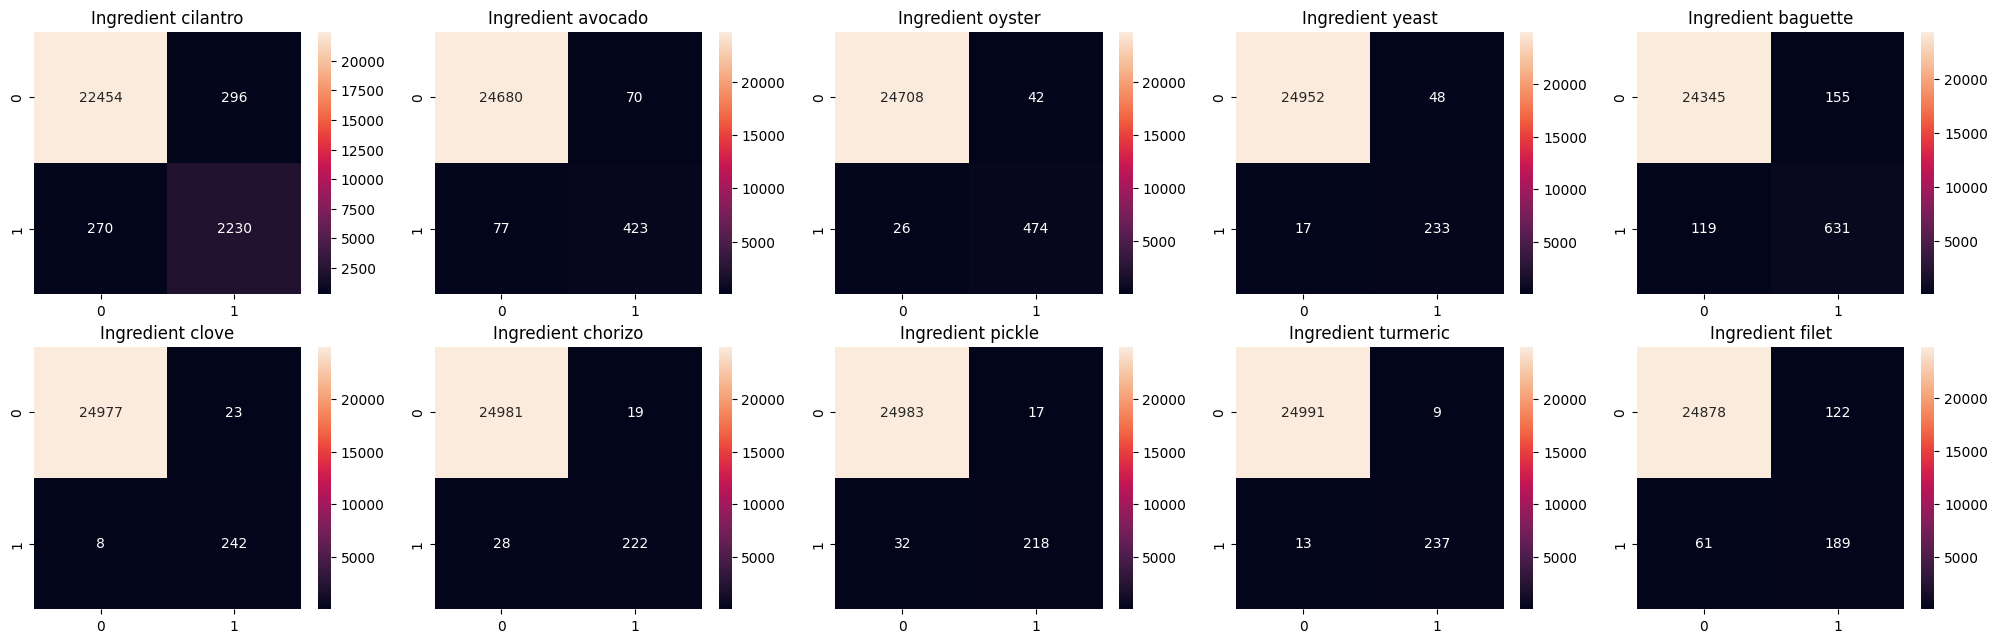

In [39]:
def plot_confusion_matrix(confusion_matrix):
    fig, ax = plt.subplots(2, 5, figsize=(25, 7.5))

    # Ensure we sample 10 random ingredients without exceeding the available number
    sampled_indices = random.sample(range(0, num_unique_ingredients), 10)
    
    for idx, i in enumerate(sampled_indices):
        sns.heatmap(confusion_matrix[i], annot=True, fmt='d', ax=ax[idx//5, idx%5])
        ax[idx//5, idx%5].set_title(f'Ingredient {idx_to_ingredient[i]}')

    plt.show()

plot_confusion_matrix(confusion_matrix)

In [42]:
# function to calculate scores for a given ingredient
def get_scores(confusion_matrix, ingredient):
    idx = ingredient_to_idx[ingredient]
    tn, fp, fn, tp = confusion_matrix[idx].ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return accuracy, precision, recall, f1 

# function to plot confusion matrix for a given ingredient
def plot_ingredient_confusion_matrix(confusion_matrix, ingredient):
    idx = ingredient_to_idx[ingredient]
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    sns.heatmap(confusion_matrix[idx], annot=True, fmt='d', ax=ax)
    ax.set_title(f'Ingredient {ingredient}')
    plt.show()

    accuracy, precision, recall, f1 = get_scores(confusion_matrix, ingredient)
    print(f"{ingredient = } | {accuracy = :.3f} | {precision = :.3f} | {recall = :.3f} | {f1 = :.3f}")

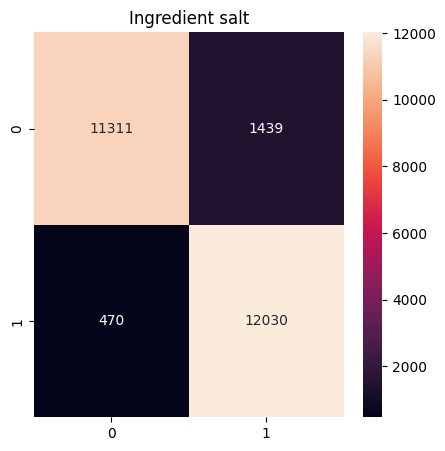

ingredient = 'salt' | accuracy = 0.924 | precision = 0.893 | recall = 0.962 | f1 = 0.926


In [43]:
plot_ingredient_confusion_matrix(confusion_matrix, 'salt')

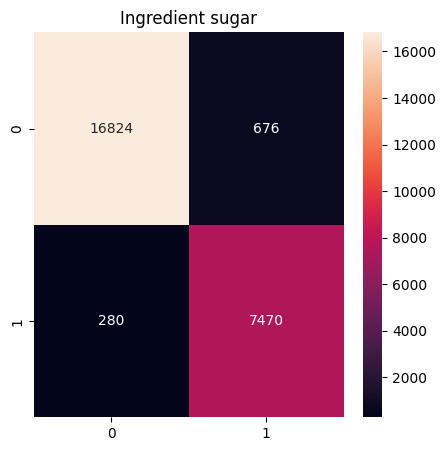

ingredient = 'sugar' | accuracy = 0.962 | precision = 0.917 | recall = 0.964 | f1 = 0.940


In [44]:
plot_ingredient_confusion_matrix(confusion_matrix, 'sugar')

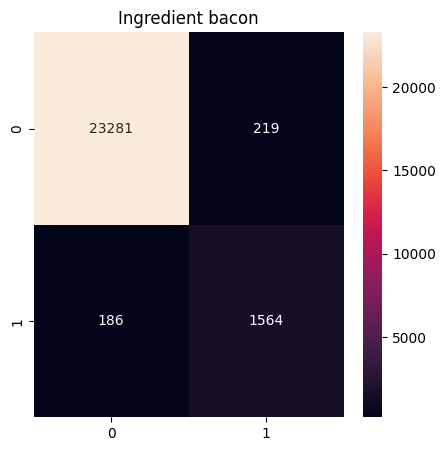

ingredient = 'bacon' | accuracy = 0.984 | precision = 0.877 | recall = 0.894 | f1 = 0.885


In [49]:
plot_ingredient_confusion_matrix(confusion_matrix, 'bacon')

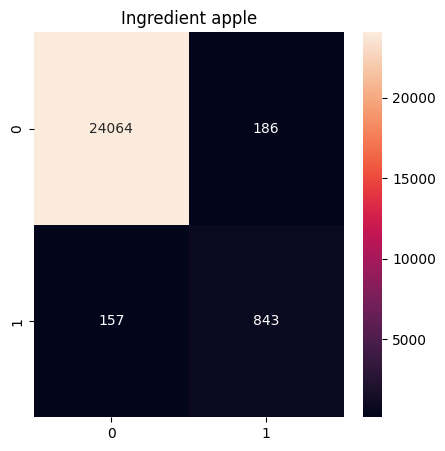

ingredient = 'apple' | accuracy = 0.986 | precision = 0.819 | recall = 0.843 | f1 = 0.831


In [45]:
plot_ingredient_confusion_matrix(confusion_matrix, 'apple')

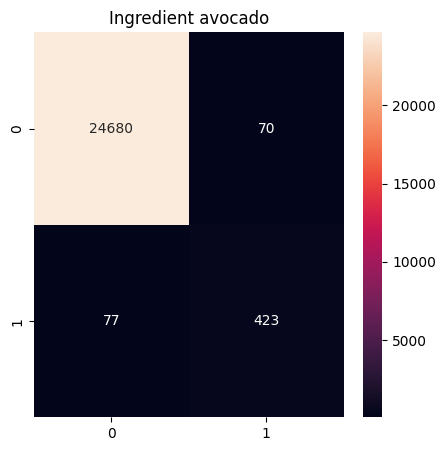

ingredient = 'avocado' | accuracy = 0.994 | precision = 0.858 | recall = 0.846 | f1 = 0.852


In [46]:
plot_ingredient_confusion_matrix(confusion_matrix, 'avocado')

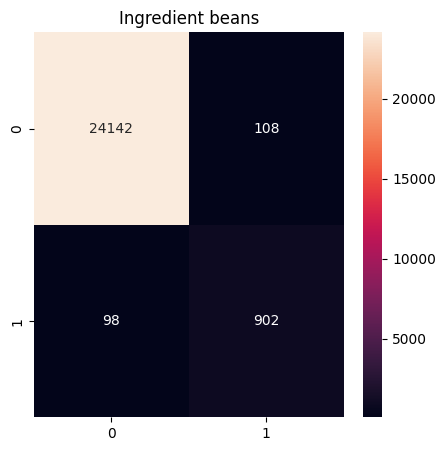

ingredient = 'beans' | accuracy = 0.992 | precision = 0.893 | recall = 0.902 | f1 = 0.898


In [47]:
plot_ingredient_confusion_matrix(confusion_matrix, 'beans')

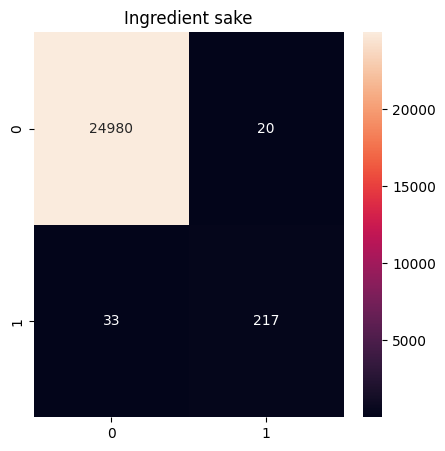

ingredient = 'sake' | accuracy = 0.998 | precision = 0.916 | recall = 0.868 | f1 = 0.891


In [48]:
plot_ingredient_confusion_matrix(confusion_matrix, 'sake')

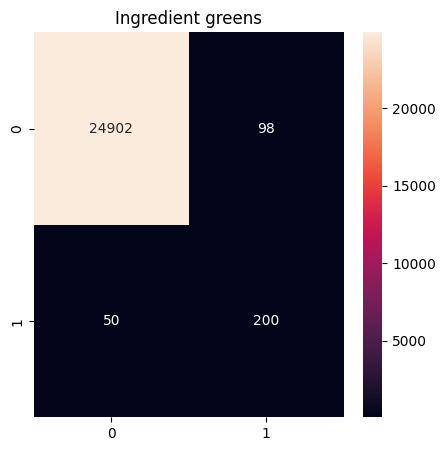

ingredient = 'greens' | accuracy = 0.994 | precision = 0.671 | recall = 0.800 | f1 = 0.730


In [50]:
plot_ingredient_confusion_matrix(confusion_matrix, 'greens')

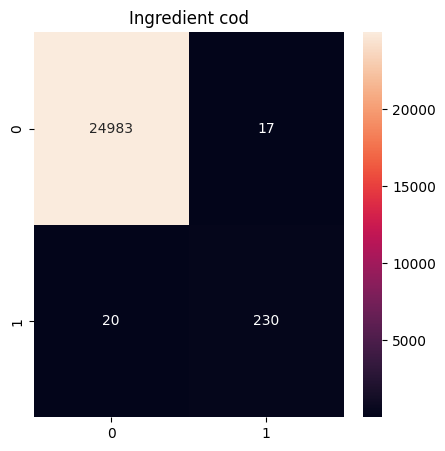

ingredient = 'cod' | accuracy = 0.999 | precision = 0.931 | recall = 0.920 | f1 = 0.926


In [52]:
plot_ingredient_confusion_matrix(confusion_matrix, 'cod')

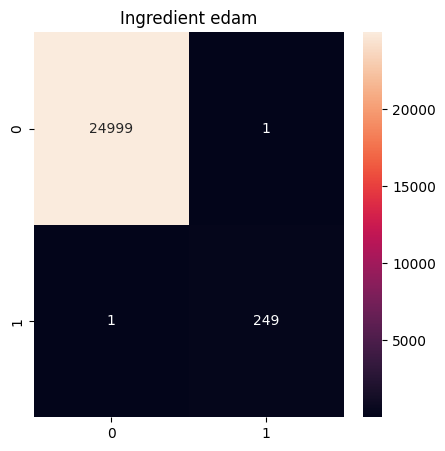

ingredient = 'edam' | accuracy = 1.000 | precision = 0.996 | recall = 0.996 | f1 = 0.996


In [51]:
plot_ingredient_confusion_matrix(confusion_matrix, 'edam')

In [82]:
# function to visualize a single prediction with metrics
def show_single_prediction(index=0):
    model.eval()
    sample = test_dataset.select([index])[0]
    fig = plt.figure(figsize=(4, 4))
    
    img = sample['image']
    img = img.resize((224, 224))
    labels = sample['labels']
    inputs = sample['pixel_values'].unsqueeze(0).to(device)
    inputs = valid_tfms(img).unsqueeze(0).to(device)
    labels = sample['ingredients']
    
    labels_text = ','.join([idx_to_ingredient[label] for label in labels])
    
    with torch.no_grad():
        logits = model(inputs)
    
    predictions = logits.sigmoid() > threshold  # convert to boolean predictions
    predictions = predictions.cpu().float().numpy().flatten() # convert boolean predictions to float

    pred_labels = np.where(predictions==1)[0] # find indices where prediction is 1
    pred_labels = ','.join([idx_to_ingredient[label] for label in pred_labels])
    
    # Calculate metrics
    true_labels = np.zeros(len(idx_to_ingredient))
    true_labels[labels] = 1
    acc = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    prec = precision_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions)
    
    label = (f"Actual: {labels_text}\nPredicted: {pred_labels}\n"
             f"Accuracy: {acc:.2f}, F1: {f1:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}")
    
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    ax.set_title(label, horizontalalignment='left')
    ax.axis('off')

    plt.show()

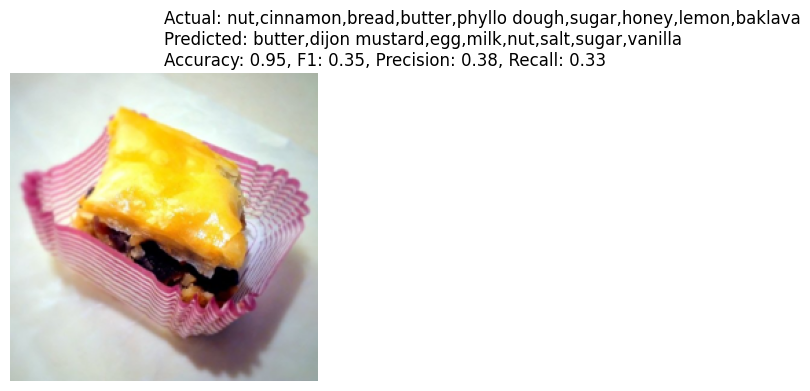

In [87]:
show_single_prediction(index=500)

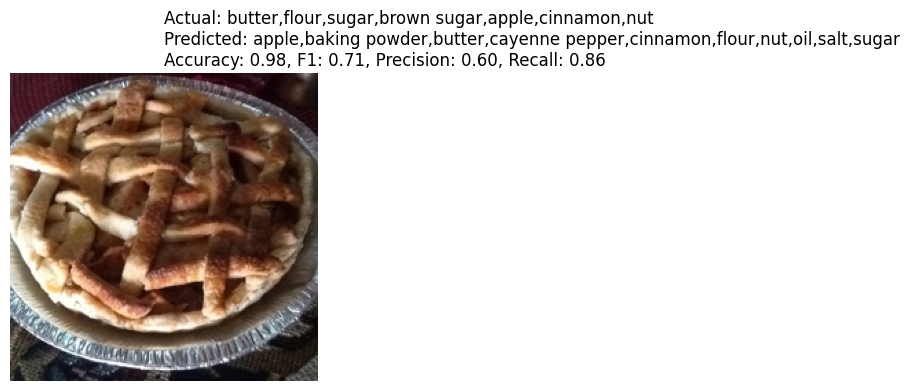

In [91]:
show_single_prediction(index=90)

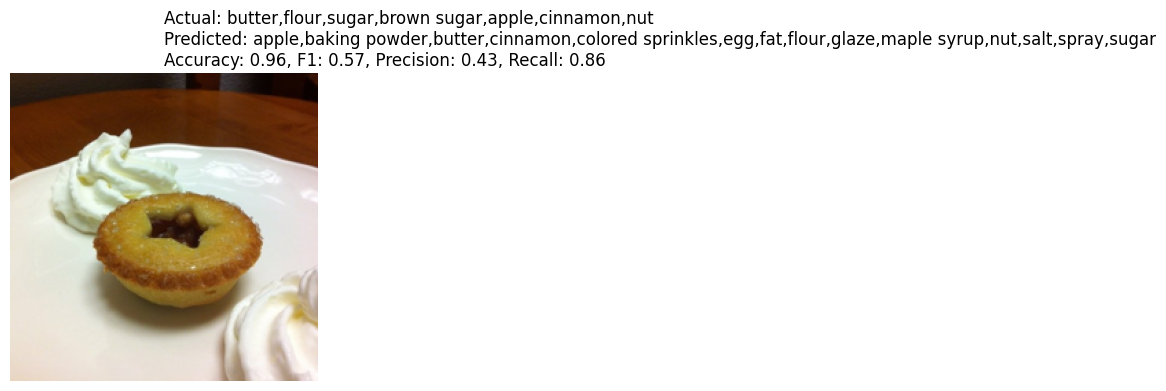

In [92]:
show_single_prediction(index=25)

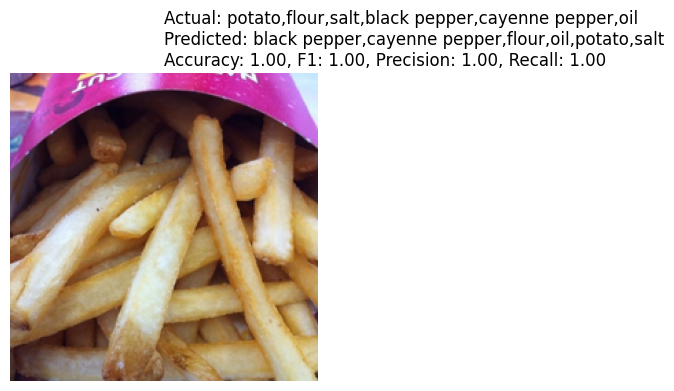

In [102]:
show_single_prediction(index=10000)

### Evaluate the model on T_500

In addition to the whole dataset evaluation, the model is tested on a subset of the data to evaluate its performance on a smaller scale. This subset is called T_500 and consists of 500 images selected from the test set. It contains at least 4 images from each of the 101 food categories, which enables a balanced presentation and at the same time reduces the calculation effort.

In [ ]:
# load dataset
data_file_500 = {"test": "../data/food-ingredients/test_500.jsonl"}

dataset_500 = datasets.load_dataset('json', data_files=data_file_500)
test_dataset_500 = dataset_500["test"].with_transform(transforms_valid)
test_loader_500 = DataLoader(test_dataset_500, batch_size=32, shuffle=False, collate_fn=collate_fn)

Generating test split: 500 examples [00:00, 62433.82 examples/s]


In [ ]:
# run evaluation on 500 samples
def predict_samples_500(model, samples, device, model_name):
    model.eval()
    predictions, actuals = [], []

    for sample in tqdm(samples, desc=f"Predicting for model {model_name}"):
        inputs = sample['pixel_values'].to(device)
        labels = sample['labels'].to(device)
        
        with torch.no_grad():
            logits = model(inputs)
        
        predictions.append(torch.sigmoid(logits).detach().cpu().numpy())
        actuals.append(labels.cpu().numpy())
    
    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)
    
    # calculate metrics
    test_accuracy = multi_label_accuracy(actuals, predictions)
    test_recall_weighted = multi_label_recall(actuals, predictions, average='weighted')
    test_precision_weighted = multi_label_precision(actuals, predictions, average='weighted')
    test_f1_macro = multi_label_f1(actuals, predictions, average='macro')
    test_f1_weighted = multi_label_f1(actuals, predictions, average='weighted')
    test_f1_samples = multi_label_f1(actuals, predictions, average='samples')

    return {
        "test_accuracy": test_accuracy,
        "test_recall_weighted": test_recall_weighted,
        "test_precision_weighted": test_precision_weighted,
        "test_f1_macro": test_f1_macro,
        "test_f1_weighted": test_f1_weighted,
        "test_f1_samples": test_f1_samples
    }

In [ ]:
# define, which models to evaluate
models = ['swin_s3_small_224', 'deit3_medium_patch16_224', 'volo_d3_224', 'vit_base_patch16_224', 'vit_base_patch32_clip_224']

def evaluate_samples_500(models, samples):
    results = {}

    for model_name in models:
        model = create_model(model_name, pretrained=True, num_classes=num_unique_ingredients)
        state_dict = torch.load(f"./models/{model_name}-pascal-epoch-14.pth")
        model.load_state_dict(state_dict)
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        
        results[model_name] = predict_samples_500(model, samples, device, model_name)

    return results

results = evaluate_samples_500(models, test_loader_500)

Predicting for model vit_base_patch32_clip_224: 100%|██████████| 16/16 [00:02<00:00,  7.53it/s]


In [ ]:
table = PrettyTable()
table.field_names = ["Model", "Accuracy", "Recall (weighted)", "Precision (weighted)", "F1 (macro)", "F1 (weighted)", "F1 (samples)"]
    
for model_name, result in results.items():
    accuracy = round(result["test_accuracy"], 4)
    recall_weighted = round(result["test_recall_weighted"], 4)
    precision_weighted = round(result["test_precision_weighted"], 4)
    f1_macro = round(result["test_f1_macro"], 4)
    f1_weighted = round(result["test_f1_weighted"], 4)
    f1_samples = round(result["test_f1_samples"], 4)

    table.add_row([model_name, accuracy, recall_weighted, precision_weighted, f1_macro, f1_weighted, f1_samples])
print(table)

+---------------------------+----------+-------------------+----------------------+------------+---------------+--------------+
|           Model           | Accuracy | Recall (weighted) | Precision (weighted) | F1 (macro) | F1 (weighted) | F1 (samples) |
+---------------------------+----------+-------------------+----------------------+------------+---------------+--------------+
|     swin_s3_small_224     |  0.9936  |       0.9323      |        0.9066        |   0.9076   |     0.9173    |    0.913     |
|  deit3_medium_patch16_224 |  0.9909  |       0.9017      |        0.8697        |   0.8721   |     0.8828    |    0.8741    |
|        volo_d3_224        |  0.9926  |       0.9121      |        0.9007        |   0.8941   |     0.9041    |    0.9018    |
|    vit_base_patch16_224   |  0.9892  |       0.8805      |        0.8494        |   0.853    |     0.8611    |    0.8525    |
| vit_base_patch32_clip_224 |  0.9689  |       0.6539      |        0.5815        |   0.5527   |     0.6

## Sources

[1] Han, J. (2021). Identification of Ingredient in Pictures of Food with Deep Learning [Masterarbeit]. Hochschule für Technik und Wirtschaft Berlin.

[2] Gao, X., Xiao, Z., & Deng, Z. (2024). High accuracy food image classification via vision transformer with data augmentation and feature augmentation. Journal of Food Engineering, 365, 111833. https://doi.org/10.1016/j.jfoodeng.2023.111833